In [21]:
# open file list_attr_celeba.txt and read the content in a list

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img_path = "data/img_align_celeba"
df = pd.read_csv("data/list_attr_celeba.csv")
df = df.head(10000)
# df = df.tail(9000)
print(df.columns)

feature_filter = {"glasses":[(df['Eyeglasses'] == 1) & (df['Male']==1), (df['Eyeglasses'] == -1) & (df['Male']==1)],
                   "beard":[(df['No_Beard'] == -1) & (df['Mustache']==1) & (df['Male'] == 1), (df['No_Beard'] == 1) & (df['Mustache']==-1) & (df['Male'] == 1)],
                   "bald": [(df['Bald']==-1) & (df['Male']==1), (df['Bald']==1)  & (df['Male']==1)]}

current_feature = "beard"

with_glasses = df['image_id'][feature_filter[current_feature][0]].tolist()
without_glasses = df['image_id'][feature_filter[current_feature][1]].tolist()

print(len(with_glasses))
print(len(without_glasses))

print(with_glasses[-5])




Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
363
2547
009930.jpg


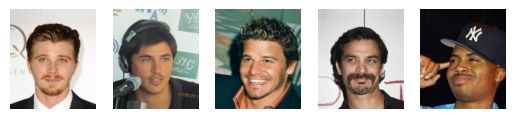

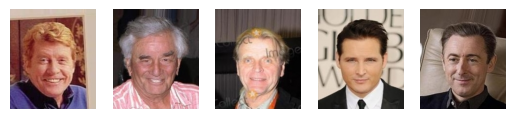

In [22]:
glass_images = [Image.open(f'{img_path}/{with_glasses[np.random.randint(0, len(with_glasses))]}') for i in range(5)]
f = plt.figure()
for i in range(5):
    # Debug, plot figure
    f.add_subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(glass_images[i])

plt.show(block=True) 

no_glass_images = [Image.open(f'{img_path}/{without_glasses[np.random.randint(0, len(without_glasses))]}') for i in range(5)]
f = plt.figure()
for i in range(5):
    # Debug, plot figure
    f.add_subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(no_glass_images[i])

plt.show(block=True) 


In [24]:
from VanillaVAE import VanillaVAE
import torch
from torchvision import transforms


INPUT_DIM = 3
Z_DIM = 500
PATH = "bestmodel_wandb5_newer.pt"
device = torch.device('cpu')

model = VanillaVAE(INPUT_DIM, Z_DIM)
checkpoint = torch.load(PATH,map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

for param in model.parameters():
    param.requires_grad = False

transform=transforms.ToTensor()

f = plt.figure()
for i in range(len(glass_images)):
    with torch.no_grad():
        out = model.forward(transform(glass_images[i]).unsqueeze(0).to(device),without_varinace=True)[0]
        
    out = out.view(-1, 3, 224, 192)
    out = np.transpose(out, (0, 2, 3, 1))
    f.add_subplot(1, len(glass_images), i + 1)
    plt.axis('off')
    plt.imshow(out[0])



RuntimeError: Error(s) in loading state_dict for VanillaVAE:
	size mismatch for fc_mu.weight: copying a param with shape torch.Size([500, 21504]) from checkpoint, the shape in current model is torch.Size([1000, 21504]).
	size mismatch for fc_mu.bias: copying a param with shape torch.Size([500]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for fc_var.weight: copying a param with shape torch.Size([500, 21504]) from checkpoint, the shape in current model is torch.Size([1000, 21504]).
	size mismatch for fc_var.bias: copying a param with shape torch.Size([500]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for decoder_input.weight: copying a param with shape torch.Size([21504, 500]) from checkpoint, the shape in current model is torch.Size([21504, 1000]).

In [ ]:
from CustomDataset import CustomDataset
from torchvision import transforms
from torch.utils.data import DataLoader


def get_avg_mu(labels):

    batch_size = 1
    glasses_dataset = CustomDataset("data/img_align_celeba/",labels,transforms.ToTensor())
    glasses_loader = DataLoader(glasses_dataset, batch_size=batch_size, shuffle=False)

    mu_sum = torch.zeros(Z_DIM)
    sigma_sum = torch.zeros(Z_DIM)
    count = len(labels)
    for batch in glasses_loader:
        #count += batch.shape[0]
        batch = batch.to(device)
        mu, sigma = model.encode(batch)
        # print(mu[0][:5])
        mu_sum = mu_sum + mu.T.sum(dim=1)
        sigma_sum = sigma_sum + sigma.T.sum(dim=1)
        # print(sigma_sum.shape)
    
    print(count)
    mu_avg = mu_sum/count
    sigma_avg = sigma_sum/count

    print(sigma_sum.shape)
    return mu_avg
 

In [ ]:
length = min(len(with_glasses), len(without_glasses))
mu_avg_glasses = get_avg_mu(with_glasses[:length])
# mu_avg_no_glasses = get_avg_mu(without_glasses)
mu_avg_no_glasses = get_avg_mu(without_glasses[:length])
delta_mu = mu_avg_glasses - mu_avg_no_glasses
print(delta_mu.shape)
print(delta_mu[4])
print(delta_mu.sum())


363
torch.Size([1000])
363
torch.Size([1000])
torch.Size([1000])
tensor(0.2644)
tensor(12.5913)


In [ ]:
torch.save(delta_mu, 'delta_mu.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


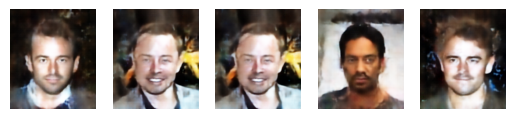

In [ ]:
coef = 2

f = plt.figure()
for i in range(len(no_glass_images)):
    with torch.no_grad():
        x = transform(no_glass_images[i]).unsqueeze(0).to(device)
        # x = torch.rand_like(transform(no_glass_images[i]).unsqueeze(0)).to(device) 
        # x = torch.zeros_like(x).to(device)
        out = model.generate_with_delta(x,delta_mu*coef,without_variance = False) #torch.zeros_like(delta_mu))
        
    out = out.view(-1, 3, 224, 192)
    out = np.transpose(out, (0, 2, 3, 1))
    f.add_subplot(1, len(no_glass_images), i + 1)
    plt.axis('off')
    plt.imshow(out[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
x
1
y


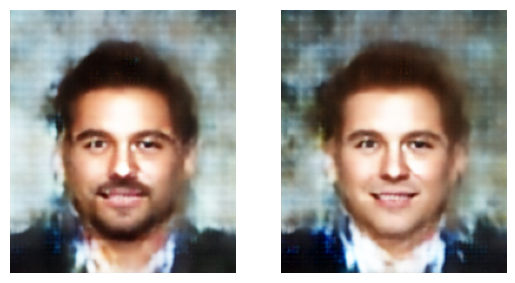

In [ ]:
f = plt.figure()
for i in range(2):
    print(i)
    with torch.no_grad():
        if i==0:
            print("x")
            out = model.decode(mu_avg_glasses)
        else:
            print("y")
            out = model.decode(mu_avg_no_glasses)
    out = out.view(-1, 3, 224, 192)
    out = np.transpose(out, (0, 2, 3, 1))
    f.add_subplot(1, 2, i + 1)
    plt.axis('off')
    plt.imshow(out[0])

In [ ]:
print(mu_avg_glasses[4])

tensor(1.1839)


In [ ]:
print(mu_avg_no_glasses[4])

tensor(0.9196)
